In [1]:
import pylab
import math
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.metrics
import pandas
import copy
import scipy.stats
import scipy.integrate

# Information Entropy on Generative Models

### Information Entropy from probability distributions

Recall from [1] and [2] the form of information entropy for a random variable $X$ with distribution $P(x)$ over a (measurable) space $x \in \mathcal{X}$

$ I(X) = \log_2 \left( \frac{1}{P(X)} \right) $,

$ H(X) = - \sum_{x \in \mathcal{X}} P(x) \log_2 P(x) $

or more generally

$ H(X) = \mathbb{E}_X [ - \log_2 P(X) ] = \mathbb{E}_X [ I(X) ]$ 

$H(X)$ represents the 'uncertainty' of $X$, or the rate of generating information from an information source $X$. $I(X)$ represents the information content of an event from $X$. This rate can be used to measure the information stored in a probabilistic generative model, and hence gives a measure of 'compression' that the model achieves over the data.

For a continuous random variable $X$ with probability density function $p(x)$ over a continuous space $x \in \mathcal{X}$, one can use differential entropy [4], which is NOT a $n\to\infty$ limit of information entropy 

$ H(X) = \int_\mathcal{X} dx p(x) \log_2 p(x) $

### The biased coin

In this case, the 'information source' is someone tossing a coin, which creates a 'message' that is the result of a coin toss. $\mathcal{X}$ is a space with two elements, $\mathcal{X} = \{ x_{head}, x_{tail} \}$, with $P(x_{tail}) = 1 - P(x_{head})$

In [2]:
def get_unbiased_coin_entropy(p_xhead):
    p_xtail = 1.0 - p_xhead
    unbiased_coin_entropy = - (p_xtail * math.log(p_xtail, 2) + p_xhead * math.log(p_xhead, 2))
    return unbiased_coin_entropy

Text(0.5, 1.0, 'information entropy of unbiased coin')

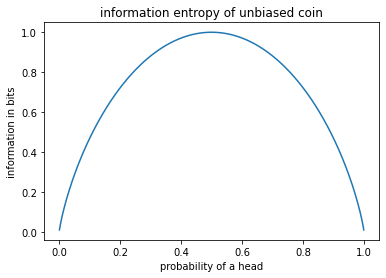

In [3]:
p_xheads = np.arange(0.5, 501)/501
pylab.plot(p_xheads, [get_unbiased_coin_entropy(x) for x in p_xheads])
pylab.xlabel("probability of a head")
pylab.ylabel("information in bits")
pylab.title("information entropy of unbiased coin")

#### Maximal certainty and uncertainty

To give this context as a message, consider the case of someone in a room tossing a coin, and transmitting a message to someone outside the room of the result of the coin toss. In practice, this message might look something like a json

{"timestamp": 20200101T12:00:00, "message_bits": "10010"}

In the perfectly even case of $P(x_{head}) = 0.5$ (which is the maximally uncertain case, and hence has the highest information entropy), the messages will look like, respectively for heads or tails,

{"timestamp": 20200101T12:00:00, "message_bits": "0"}

{"timestamp": 20200101T12:10:00, "message_bits": "1"}

and the average message length is 1 bit.

For the perfectly uneven case of $P(x_{head}) = 1.0$ or $P(x_{head}) = 0.0$ (which is the completely certain case, and has zero information entropy), the result of each coin toss will always be the same; there is in fact no value in sending the message bits. The messages will look like

{"timestamp": 20200101T12:20:00, "message_bits": ""}

and the average message length is 0 bits.

#### Partial certainty

To consider some kind of rate, consider repeated experiments reported as a string of bits. For the unbiased coin case, this would look like a random string

1001010110101010

whereas the completely biased case would look like a bit string

0000000000000000 .

This latter case has zero information rate coming out as the string progresses (and may be familiar as a bit string that compresses down very well). A partial certain case, e.g. where $P(x_{head}) = 0.1$ would look something like

0000100000000010

which yields a smaller rate of information coming from the series of experiments.

### Conditional Information Entropy

As per [1], [3], information entropy can be extended to conditional distributions. The definition above extends to a particular condition by 

$ H(Y|X=x) = - \sum_{y \in \mathcal{Y}} P(y | X=x) \log_2 P(y | X=x) $

and defining

$ H(Y|X) = \sum_{x \in \mathcal{X}} P(x) H(Y|X=x) $

for an information entropy on conditional random variables. From the definition of conditional probability, one can show that

$ H(Y|X) = H(X|Y) - H(X) + H(Y) $

### Naive Bayes classifier

Taking a naive Bayes classifier and training it on a dataset, the model should have learned a prior distribution and a conditional distribution. The conditional information entropy should then be calculable

In [4]:
# data import and shaping
wine = sklearn.datasets.load_wine(as_frame=True)
df = copy.deepcopy(wine["data"])
df["target"] = wine["target"]
print(f"feature column names: {wine['data'].keys()}")
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(wine["data"], wine["target"], test_size=0.2, random_state=42, shuffle=True)

feature column names: Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')


In [5]:
# to make calculations easier, train on a single feature
feature = "hue"
gnb_clf = sklearn.naive_bayes.GaussianNB()
gnb_clf.fit([[x] for x in X_train[feature]], y_train)
y_pred = gnb_clf.predict([[x] for x in X_test[feature]])
sklearn.metrics.confusion_matrix(y_pred, [x for x in y_test])

array([[8, 6, 0],
       [6, 7, 0],
       [0, 1, 8]])

Since the generated model is a Gausian Naive Bayes with one feature over three classification classes, the priors should be a discrete probability distribution over each class, and each class should have a 1D Gaussian Bayesian distribution.

In [6]:
print(f"priors for each class {gnb_clf.class_prior_}")
print(f"means for each class {gnb_clf.theta_}")
print(f"variances for each class {gnb_clf.var_}")

priors for each class [0.31690141 0.40140845 0.28169014]
means for each class [[1.064     ]
 [1.06063158]
 [0.68675   ]]
variances for each class [[0.01265067]
 [0.0444069 ]
 [0.01445194]]


Taking a naive continuum definition, one obtains

$H(X|Y) = -\sum_{y \in \mathcal{Y}} P(y) \int_\mathbb{R} dx p(x|y) \log_2 p(x|y)$

where $p(x|y)$ is probability density function for a (single variable) Gaussian variable. From the formulae on [4], one obtains for the naive bayes classifier above

$H(X|Y) = -\sum_{y \in \mathcal{Y}} P(y) \frac{1}{2}\log_2 \left(2\pi e\sigma_y^2 \right)$

and correspondingly for multivariate Gaussians

$H(X|Y) = -\sum_{y \in \mathcal{Y}} P(y) \frac{1}{2}\log_2 \left((2\pi e)^N\det(\Sigma_y) \right)$

As a toy example, consider just the information entropy of a single Gaussian as a function of variance:

Text(0.5, 1.0, 'Differential entropy of a Gaussian variable')

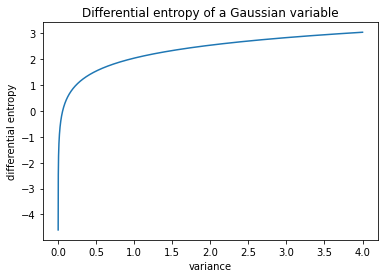

In [7]:
def gaussian_diff_entropy(variance): 
    return 0.5 * math.log(2 * math.pi * math.e * variance, 2)

variances = np.arange(1,40000)/10000
pylab.plot(variances, [gaussian_diff_entropy(x) for x in variances])
pylab.xlabel("variance")
pylab.ylabel("differential entropy")
pylab.title("Differential entropy of a Gaussian variable")

As the variance increases, so does the differential entropy, which reflects the 'uncertainty' of the random variable. This plot also demonstrates some of the issues with differential entropy, such as not being positive definite (it is also not co-ordinate invariant...).

One can calculate $H(X|Y)$ for the model

In [8]:
def gaussian_nb_entropy_xy(clf):
    ys = clf.class_prior_
    variances = [x[0] for x in clf.var_]
    entropy = 0.0
    for y, var in zip(ys, variances):
        entropy -= y * gaussian_diff_entropy(var)
    return entropy

print(f"H(X|Y) for Gaussian Naive Bayes model = {gaussian_nb_entropy_xy(gnb_clf)}")

H(X|Y) for Gaussian Naive Bayes model = 0.714586735089024


And from knowledge of $H(X)$ and $H(Y)$, one can then calculate $H(Y|X)$

$H(X)$ is an intricate quantity to calculate, since directly one would try and calculate it from $p(x)$ by $H(X) = \int dx p(x) log_2 p(x)$. Using the naive Bayes classifier, one can compute an estimator $p(x) = \sum_{y\in\mathcal{Y}} p(x|y)p(y)$, although this will not be the true $p(x)$

In [9]:
def gaussian_nb_entropy_x(clf):
    gaussian_distributions = [scipy.stats.norm(mu[0], math.sqrt(var[0])) for mu, var in zip(clf.theta_, clf.var_)]
    def px(x):  # p(x) = sum_k p(x|k) p(k)
        return sum([pxk.pdf(x) * pk for pxk, pk in zip(gaussian_distributions, clf.class_prior_)], 0)
    def pxlogpx(x):
        if x != - np.inf and x != np.inf and px(x) > 0.0:
            return px(x) * math.log(px(x), 2)
        else:
            return 0.0
    h_x = scipy.integrate.quad(pxlogpx, -np.inf, np.inf)[0]
    return h_x

print(f"H(X) for Gaussian Naive Bayes model = {gaussian_nb_entropy_x(gnb_clf)}")

H(X) for Gaussian Naive Bayes model = 0.09948561115347716


In [10]:
def gaussian_nb_entropy_yx(clf):
    h_xy = gaussian_nb_entropy_xy(clf)
    h_y = sum([py * math.log(py,2) for py in clf.class_prior_],0)  # discrete distribution, so easy calc
    h_x = gaussian_nb_entropy_x(gnb_clf)
    # print((h_xy, h_y, h_x))
    return h_xy - h_x + h_y
    
print(f"H(Y|X) for Gaussian Naive Bayes model = {gaussian_nb_entropy_yx(gnb_clf)}")

H(Y|X) for Gaussian Naive Bayes model = -0.9537639960077258


Training on different features will yield different results

In [11]:
feature = "ash"
gnb_clf_ash = sklearn.naive_bayes.GaussianNB()
gnb_clf_ash.fit([[x] for x in X_train[feature]], y_train)
y_pred = gnb_clf.predict([[x] for x in X_test[feature]])
sklearn.metrics.confusion_matrix(y_pred, [x for x in y_test])

array([[ 0,  0,  0],
       [14, 14,  8],
       [ 0,  0,  0]])

In [12]:
print(f"H(X|Y) for Gaussian Naive Bayes model = {gaussian_nb_entropy_xy(gnb_clf_ash)}")
print(f"H(Y|X) for Gaussian Naive Bayes model = {gaussian_nb_entropy_yx(gnb_clf_ash)}")
print(f"H(X) for Gaussian Naive Bayes model = {gaussian_nb_entropy_x(gnb_clf_ash)}")

H(X|Y) for Gaussian Naive Bayes model = -0.017645869443382367
H(Y|X) for Gaussian Naive Bayes model = -1.6859966005401321
H(X) for Gaussian Naive Bayes model = -0.17714204967457986


This model is far more "certain" as a probability distribution, since it predicts only to class 1.

### Logistic regression

What happens when one tries this on a statistical discriminative model? As an example, consider applying the same work to a Logistic Regression model.

In [13]:
# train on a single feature
feature = "hue"
logreg_clf = sklearn.linear_model.LogisticRegression()
logreg_clf.fit([[x] for x in X_train[feature]], y_train)
y_pred = logreg_clf.predict([[x] for x in X_test[feature]])
sklearn.metrics.confusion_matrix(y_pred, [x for x in y_test])

array([[ 0,  0,  0],
       [14, 13,  0],
       [ 0,  1,  8]])

The model is discriminative and statistical; and therefore yields probabilities $P(Y|X)$; $P(X|Y)$ is unavailable.

In [14]:
logreg_clf.predict_proba([[-0.1], [0.3]])

array([[0.00402641, 0.00463544, 0.99133816],
       [0.03561817, 0.04242276, 0.92195907]])

Which means that $H(Y|X=x)$ is calculable. Calculation of $H(Y|X) = \int_\mathbb{R} dx p(x) H(Y|X=x) $ then requires knowledge of $p(x)$. Recall the generative model allowed the calculation of an estimate of $p(x)$.

### Conclusions on Naive Bayes example

The machinery and calculations used only assume a generative model. From that model, once can compute $H(Y|X), H(X|Y)$ and $H(X)$. A good question is - which if those measures might be useful for various purposes? Given that $Y$ is the classification space, and $X$ is the underlying feature space, one might say that $H(X)$, which could be interpreted as the model's entropy over the feature space, is indicative of the model's messaging/encoding of the feature space.

Following [1], $H(A|B)$ is the entropy of $A$ when $B$ is known. $H(Y|X)$ would then be the entropy of the classification given that the input of the model is known. $H(X|Y)$ would be the entropy of the feature space given that the output classification is known. $H(X)$ would then be, from the model's perspective, the entropy of the feature space.

### References

[1] Shannon, C. "A mathematical theory of communication", https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf

[2] Wikipedia, "Entropy", https://en.wikipedia.org/wiki/Entropy_(information_theory)

[3] Wikipedia, "Conditional Entropy", https://en.wikipedia.org/wiki/Conditional_entropy

[4] Wikipedia, "Differential Entropy", https://en.wikipedia.org/wiki/Differential_entropy